In [86]:
import os
import pandas as pd
import numpy as np
from collections import Counter
import re
import functools 
import operator

from sklearn import utils

import datetime
import csv
#import nltk
from sklearn.preprocessing import MultiLabelBinarizer


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

from sklearn.model_selection import train_test_split
pd.options.display.max_seq_items = 2000

# Data Loading & Preprocessing Methods
- extract datetype data info
    - year, month, day
- detect outlier
- preprocess strings for categorical data
- print categorical data

In [87]:
# path for the csv files
DATA_PATH = os.path.join(os.getcwd(), 'data')

# loading data to pandas dataframe
def load_data(file_name): 
    file_path = os.path.join(DATA_PATH, file_name) 
    return pd.read_csv(file_path, parse_dates = ['purchase_date', 'release_date'])

def extract_dateinfo(df, col_name, datetype='year'):
    '''
    extract date type into specific year, month, date
    '''
    date_type = {'year': df[col_name].dt.year, 'month': df[col_name].dt.month, 'day': df[col_name].dt.day}[datetype]
    
    df.loc[:, col_name+'_'+ datetype] = date_type
    return df

#Outlier detection
def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    
    outlier_indices = []
    
    for col in features:
        # calculating interquartile range
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR  
        
        # get the indices of outliers for feature col
        outliers_in_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        
        # append the indices to oulier_indices
        outlier_indices.extend(outliers_in_col)
    
    outlier_indices = Counter(outlier_indices)
    result = list(k for k, v in outlier_indices.items() if v > n)
    
    return result

def process_string(string):
    '''
    split strings in categories/tags/genres 
    make all the words in lowercase
    remove all '-'
    '''
    string = string.lower()
    punctuation = "-"
    
    string = ''.join('' if c.isalpha()==False else c for c in string)
    
    return string

def get_cate_type_data(df, column_name):
    cate_list = list(df[column_name].apply(lambda x: set(x)))
    cate_list = set(functools.reduce(operator.iconcat, cate_list, []))
    return cate_list
    



# Methods for Exploring Categorical Data
1. create dataframe for one-hot categorical data & play time
2. get the mean play time under each categorical data
3. create dataframe containing mean play time and number of games under each categorical data

In [88]:
def create_cate_type_df(cate_type='categories'):
    '''
    return one hot dataframe with 'playtime_forever'
    '''
    
    cate_df = game_info.loc[:, ['playtime_forever', cate_type]]
    temp = pd.get_dummies(cate_df[cate_type].apply(pd.Series).stack()).sum(level=0)
    cate_df = pd.concat([cate_df, temp], axis=1, sort=False).drop(columns=[cate_type])
    
    return cate_df



def get_mean_time_df(cate_df):
    '''
    index: tages/categories/genres
    columns: 
        number of game in that cate/tag/genre
        mean play time of all the games in that cate/tag/genre
    '''
    cate_df_copy = cate_df.copy()
    
    def __get_mean_playTime__(column):
        temp = cate_df_copy.loc[cate_df_copy[column.name] > 0]
        return temp['playtime_forever'].mean(skipna=True)
    
    
    mean_play_time_series = cate_df_copy.apply(__get_mean_playTime__, axis=0).drop(['playtime_forever'])
    
    
    cate_df_copy = cate_df_copy.transpose()
    
    cols = cate_df_copy.columns
    bt = cate_df_copy.apply(lambda x: x > 0)
    
    # number of game for each category
    num_game = bt.apply(lambda x: len(cols[x.values]), axis=1).drop(['playtime_forever'])
    
    cate_df_copy = pd.concat([num_game, mean_play_time_series], axis=1)
    cate_df_copy.columns = ['num of games', 'mean play time']
    
    return cate_df_copy.sort_values(by=['mean play time'])



def get_correlation(game_info, category_df):
    #cate_df = game_info[['genres', 'categories', 'tags']]
    game_df_copy = game_info.copy()
    #game_df_copy.loc[:, 'all_cate'] = cate_df.apply(__unique_tags__, axis=1)
    game_df_copy.drop(columns=['genres', 'categories', 'tags'], inplace=True)
    
    cate_df = pd.get_dummies(game_df_copy['all_cate'].apply(pd.Series).stack()).sum(level=0)
    game_df_copy = pd.concat([game_df_copy, cate_df], axis=1).drop(columns=['all_cate'])
    
    features = list(category_df.columns) 
    corr = game_df_copy[features].corr()
    
    return corr

def get_high_corr_list(corr, threshold=0.1):
    '''
    |correlation| > 0.1
    '''
    corr_list = corr.iloc[0,:].sort_values(ascending=False).drop('playtime_forever')
    corr_list = list(corr_list[np.abs(corr_list.values) > threshold].index)
    
    return corr_list

def get_cate_info(cate_type='categories'):
    '''
    info
        - df
        - correlation df
        - high correlation item list
        - mean time df
    '''
    info = {}
    
    df = create_cate_type_df(cate_type=cate_type)
    info['df'] = df
    
    corr_df = get_correlation(game_info, df)
    info['corr_df'] = corr_df
    
    high_corr_list = get_high_corr_list(corr_df, threshold=0.18)
    info['high_corr_list'] = high_corr_list
    

    info['mean_time_df'] = get_mean_time_df(df)
    
    return info

def count_cate_game(df):
    df_copy = df.copy()
    df_copy = df_copy.transpose()
    return df_copy.astype(bool).sum(axis=1)

# Graphing Methods
- graph mean time under each tag

In [89]:
def plot_mean_time(mean_time_df, figsize=(50, 3)):

    names = list(mean_time_df.index.values)
    values = list(mean_time_df.iloc[:, 1])

    plt.figure(figsize=figsize)
    plt.scatter(names, values)
    plt.show()

def plot_heat_map(corr, figsize=(30, 9)):
    plt.figure(figsize=figsize)
    g = sns.heatmap(corr, annot=True, cmap = "coolwarm")

# Applying Preprocessing Methods
1. load data
2. drop outlier
3. merge training dataset and testing dataset
4. filling NaN
5. convert boolean value to 0 & 1
6. preprocess categorical data

In [90]:
train_set = load_data('train.csv')
test_set = load_data('test.csv')

In [91]:
# Drop outliers from training data
outliers_to_drop = detect_outliers(train_set, 1 ,['price', 'total_positive_reviews', 'total_negative_reviews'])
train_set.loc[outliers_to_drop]
train_set = train_set.drop(outliers_to_drop, axis = 0).reset_index(drop=True)

# merge training data and testing data 
game_info =  pd.concat(objs=[train_set, test_set], axis=0, sort=False).reset_index(drop=True)

#fill missing purchase date with the most frequent value in purchase_date column
game_info['purchase_date'].fillna(game_info['purchase_date'].mode()[0], inplace=True)


#fille missing number of positive_reviews and negative_reviews with zeros
game_info['total_positive_reviews'].fillna(0.0, inplace=True)
game_info['total_negative_reviews'].fillna(0.0, inplace=True)

#print(game_info.isnull().any().any())
#game_info['total_reviews_count'] = game_info['total_positive_reviews'] + game_info['total_negative_reviews']

#transfer boolean values to 1(true) and 0(false)
game_info['is_free'] = game_info['is_free'].map({False: 0.0, True: 1.0})

# extract year value
game_info = extract_dateinfo(game_info, 'purchase_date')
game_info = extract_dateinfo(game_info, 'release_date')
game_info['time_interval'] = game_info['purchase_date_year'] - game_info['release_date_year']
game_info.drop(columns=['purchase_date', 'release_date'], inplace=True)

game_info.drop(columns=['id'], inplace=True)

# split strings in the categorical columns
game_info['genres'] = game_info['genres'].str.split(',').apply(lambda x: list(map(process_string, x)))
game_info['categories'] = game_info['categories'].str.split(',').apply(lambda x: list(map(process_string, x)))
game_info['tags'] = game_info['tags'].str.split(',').apply(lambda x: list(map(process_string, x)))

In [92]:
train_len = train_set.shape[0]
test_len = test_set.shape[0]

In [93]:
train_len

324

# Exploring Numerical Data

In [94]:
game_info[:train_len]['playtime_forever'].describe()

count    324.000000
mean       1.924640
std        7.734992
min        0.000000
25%        0.000000
50%        0.033333
75%        1.104167
max       92.633333
Name: playtime_forever, dtype: float64

In [95]:
categorical_features = ['genres', 'categories', 'tags']
numerical_features = [e for e in list(game_info.columns) if e not in ('categorical_features')]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


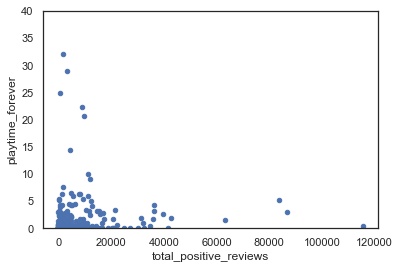

In [96]:
x = 'total_positive_reviews'
y = 'playtime_forever'
data = game_info[:train_len].loc[:, [x, y]]
data.plot.scatter(x=x, y=y, ylim=(0,40));

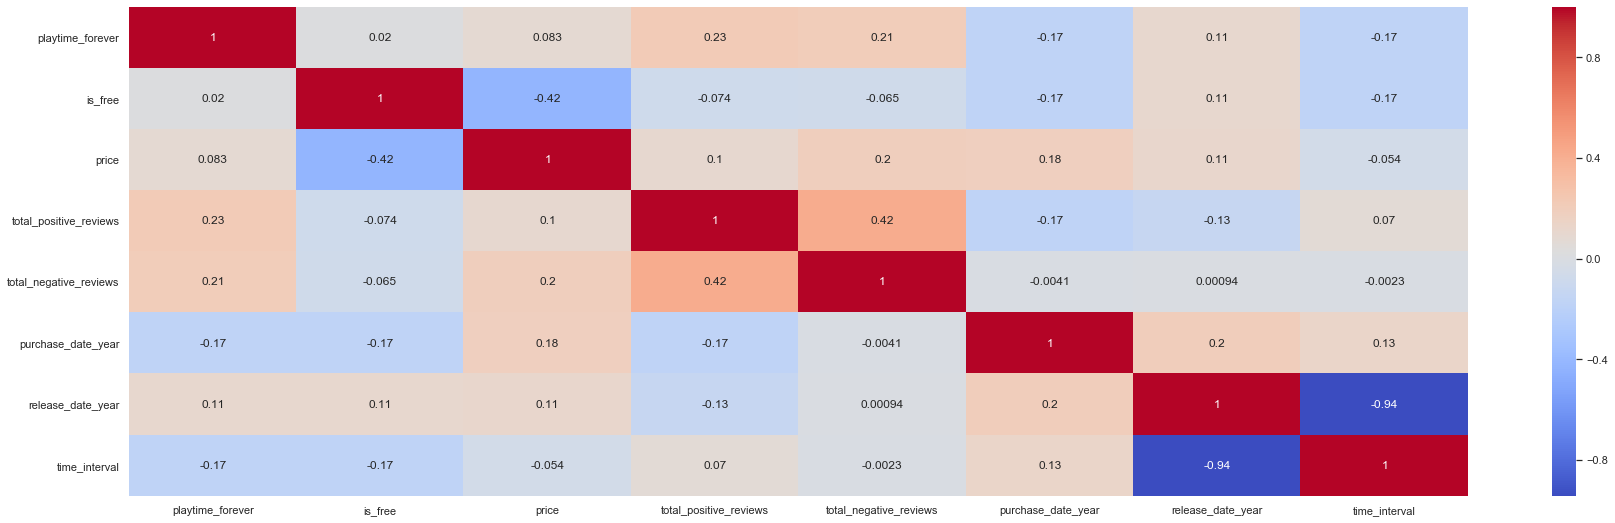

In [97]:
num_corr = game_info[numerical_features].corr()
plot_heat_map(num_corr)

# Exploring Catagorical Data

## Genres

In [98]:
genre_df = create_cate_type_df(cate_type='genres')

In [99]:
test_genre_set = get_cate_type_data(game_info[train_len:], 'genres')
train_genre_set = get_cate_type_data(game_info[:train_len], 'genres')
genre_list = list(test_genre_set.intersection(train_genre_set))

In [100]:
len(test_genre_set)

14

In [101]:
len(train_genre_set)

20

In [102]:
genre_list

['massivelymultiplayer',
 'simulation',
 'rpg',
 'casual',
 'freetoplay',
 'adventure',
 'indie',
 'violent',
 'nudity',
 'action',
 'earlyaccess',
 'sports',
 'strategy',
 'gore']

In [103]:
temp_genre_df = genre_df[['playtime_forever'] + genre_list]
genre_game_count = count_cate_game(temp_genre_df).sort_values()

In [104]:
get_high_corr_list(temp_genre_df.corr(), threshold=0)

['rpg',
 'strategy',
 'massivelymultiplayer',
 'adventure',
 'simulation',
 'freetoplay',
 'sports',
 'indie',
 'action',
 'nudity',
 'violent',
 'casual',
 'earlyaccess',
 'gore']

In [105]:
genre_game_count

nudity                    5
sports                    7
gore                      7
violent                  10
massivelymultiplayer     11
earlyaccess              11
freetoplay               22
casual                   50
simulation               72
strategy                 96
rpg                     116
action                  198
adventure               221
indie                   221
playtime_forever        261
dtype: int64

In [106]:
low_freq_genre = list(genre_game_count[genre_game_count.values < 90].index)


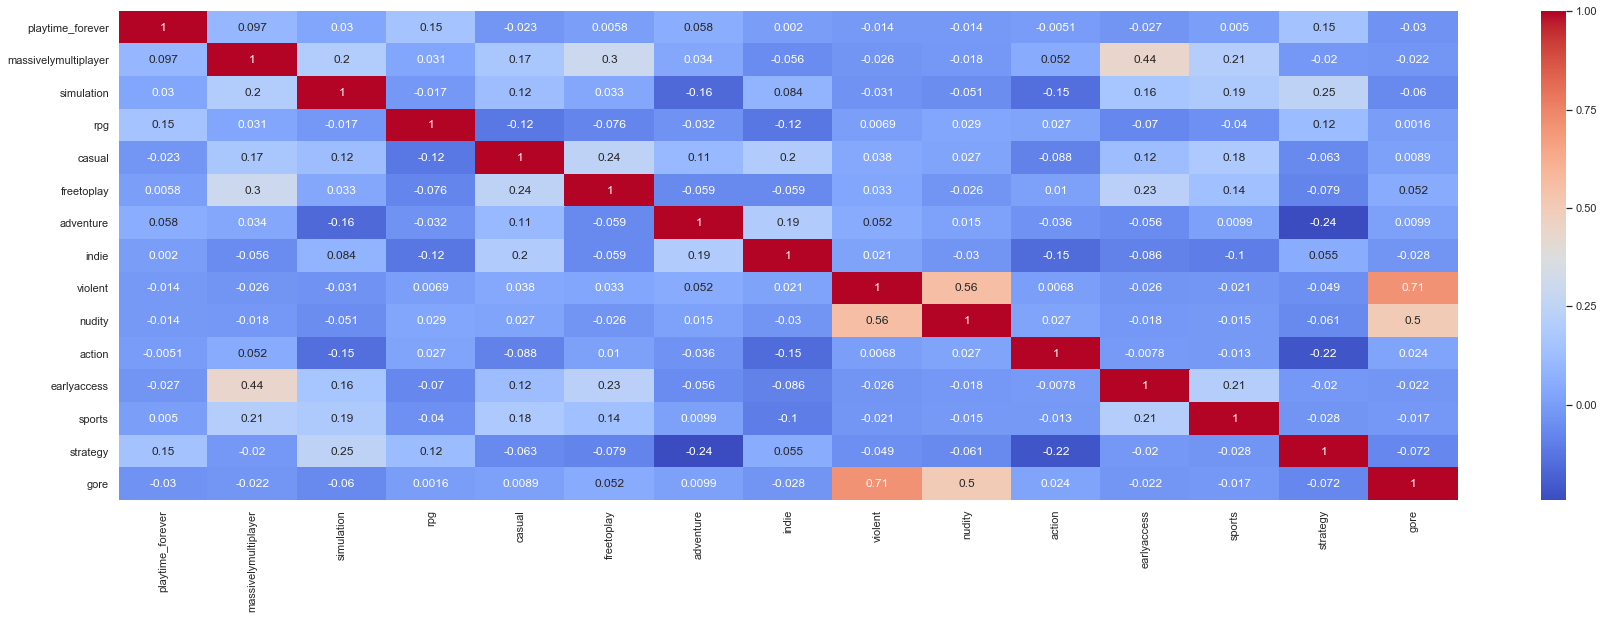

In [107]:
plot_heat_map(temp_genre_df.corr())

In [108]:
delete_genres = ['gore', 'nudity'] + low_freq_genre
new_genre_list = [e for e in genre_list if e not in delete_genres]
delete_genres

['gore',
 'nudity',
 'nudity',
 'sports',
 'gore',
 'violent',
 'massivelymultiplayer',
 'earlyaccess',
 'freetoplay',
 'casual',
 'simulation']

In [109]:
new_genre_df = genre_df.loc[:, ['playtime_forever'] + new_genre_list]
new_genre_list

['rpg', 'adventure', 'indie', 'action', 'strategy']

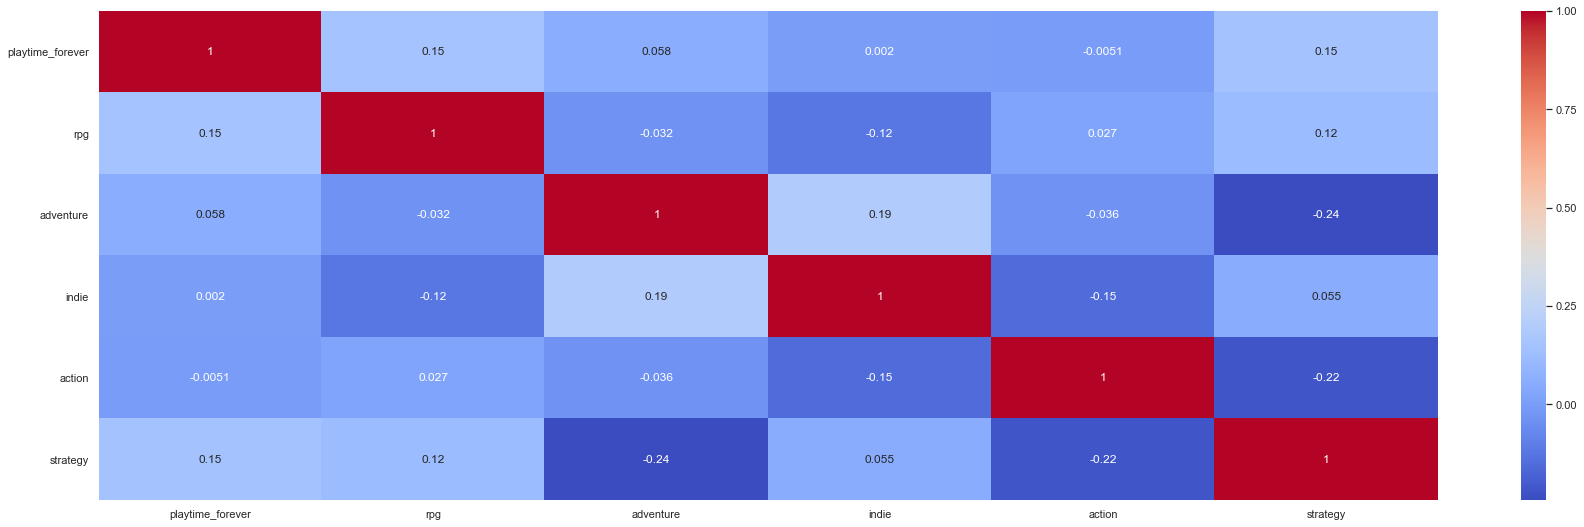

In [110]:
plot_heat_map(new_genre_df.corr())

## Categories

In [111]:
cate_df = create_cate_type_df(cate_type='categories')
cate_df

,playtime_forever,captionsavailable,commentaryavailable,coop,crossplatformmultiplayer,fullcontrollersupport,inapppurchases,includesleveleditor,includessourcesdk,localcoop,...,singleplayer,stats,steamachievements,steamcloud,steamleaderboards,steamtradingcards,steamvrcollectibles,steamworkshop,valveanticheatenabled,vrsupport
0,0.000000,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0
1,0.016667,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0.000000,0,0,0,0,1,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0
3,1.533333,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,0,1,0,0
4,22.333333,0,0,1,0,1,0,0,0,0,...,1,0,1,1,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,NaN,0,0,0,0,1,0,0,0,0,...,1,0,1,1,1,1,0,0,0,0
410,NaN,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
411,NaN,0,0,0,1,0,0,0,0,0,...,1,0,1,1,0,1,0,1,0,0
412,NaN,0,0,1,1,0,0,0,0,0,...,1,1,1,1,1,0,0,0,0,0


In [112]:
test_cate_set = get_cate_type_data(game_info[train_len:], 'categories')
train_cate_set = get_cate_type_data(game_info[:train_len], 'categories')
cate_list = list(test_cate_set.intersection(train_cate_set))

In [113]:
test_cate_set

{'captionsavailable',
 'commentaryavailable',
 'coop',
 'crossplatformmultiplayer',
 'fullcontrollersupport',
 'inapppurchases',
 'includesleveleditor',
 'includessourcesdk',
 'localcoop',
 'localmultiplayer',
 'mmo',
 'multiplayer',
 'onlinecoop',
 'onlinemultiplayer',
 'partialcontrollersupport',
 'remoteplayonphone',
 'remoteplayontablet',
 'remoteplayontv',
 'sharedsplitscreen',
 'singleplayer',
 'stats',
 'steamachievements',
 'steamcloud',
 'steamleaderboards',
 'steamtradingcards',
 'steamvrcollectibles',
 'steamworkshop',
 'vrsupport'}

In [114]:
len(train_cate_set)

29

In [115]:
cate_list

['onlinemultiplayer',
 'steamleaderboards',
 'steamtradingcards',
 'includesleveleditor',
 'multiplayer',
 'crossplatformmultiplayer',
 'remoteplayonphone',
 'steamachievements',
 'captionsavailable',
 'remoteplayontv',
 'fullcontrollersupport',
 'stats',
 'steamworkshop',
 'sharedsplitscreen',
 'remoteplayontablet',
 'steamvrcollectibles',
 'localcoop',
 'onlinecoop',
 'localmultiplayer',
 'coop',
 'mmo',
 'commentaryavailable',
 'partialcontrollersupport',
 'inapppurchases',
 'includessourcesdk',
 'singleplayer',
 'vrsupport',
 'steamcloud']

In [116]:
cate_df = cate_df[['playtime_forever'] + list(cate_list)]
cate_game_count = count_cate_game(cate_df).sort_values()

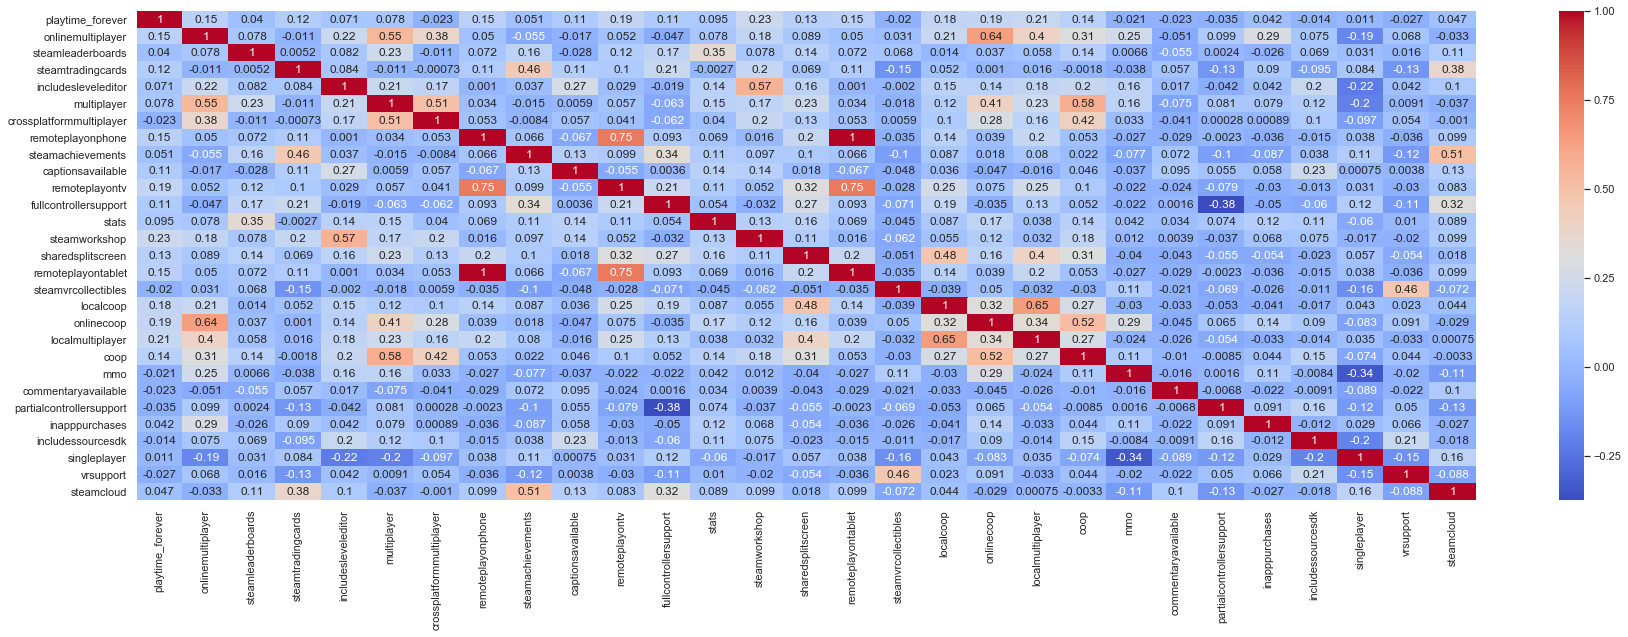

In [117]:
plot_heat_map(cate_df.corr())

In [118]:
cate_df.corr().iloc[0,:].sort_values()

partialcontrollersupport   -0.034787
vrsupport                  -0.026722
commentaryavailable        -0.023313
crossplatformmultiplayer   -0.023229
mmo                        -0.020879
steamvrcollectibles        -0.019706
includessourcesdk          -0.013866
singleplayer                0.010677
steamleaderboards           0.039991
inapppurchases              0.042027
steamcloud                  0.047326
steamachievements           0.050731
includesleveleditor         0.071366
multiplayer                 0.078357
stats                       0.095132
fullcontrollersupport       0.106971
captionsavailable           0.107387
steamtradingcards           0.122928
sharedsplitscreen           0.134631
coop                        0.144540
onlinemultiplayer           0.146149
remoteplayontablet          0.149199
remoteplayonphone           0.149199
localcoop                   0.178311
onlinecoop                  0.189831
remoteplayontv              0.190142
localmultiplayer            0.208993
s

In [119]:
cate_game_count

includessourcesdk             2
mmo                           6
commentaryavailable           7
steamvrcollectibles          10
vrsupport                    11
inapppurchases               11
remoteplayontv               13
localmultiplayer             16
remoteplayontablet           19
remoteplayonphone            19
localcoop                    24
stats                        31
captionsavailable            35
crossplatformmultiplayer     37
sharedsplitscreen            40
includesleveleditor          43
onlinecoop                   43
steamworkshop                55
onlinemultiplayer            55
steamleaderboards            61
partialcontrollersupport     67
coop                         71
multiplayer                 103
fullcontrollersupport       175
steamcloud                  258
playtime_forever            261
steamtradingcards           269
steamachievements           318
singleplayer                402
dtype: int64

In [121]:
high_freq_cate = list(cate_game_count[cate_game_count.values >= 90].index)
high_freq_cate

['multiplayer',
 'fullcontrollersupport',
 'steamcloud',
 'playtime_forever',
 'steamtradingcards',
 'steamachievements',
 'singleplayer']

In [122]:
high_corr_list = get_high_corr_list(cate_df.corr())
high_corr_list

['steamworkshop',
 'localmultiplayer',
 'remoteplayontv',
 'onlinecoop',
 'localcoop',
 'remoteplayonphone',
 'remoteplayontablet',
 'onlinemultiplayer',
 'coop',
 'sharedsplitscreen',
 'steamtradingcards',
 'captionsavailable',
 'fullcontrollersupport']

In [123]:
temp_cate_list = [e for e in high_corr_list if e not in high_freq_cate]

temp_cate_list = high_freq_cate + temp_cate_list


temp_cate_list

['multiplayer',
 'fullcontrollersupport',
 'steamcloud',
 'playtime_forever',
 'steamtradingcards',
 'steamachievements',
 'singleplayer',
 'steamworkshop',
 'localmultiplayer',
 'remoteplayontv',
 'onlinecoop',
 'localcoop',
 'remoteplayonphone',
 'remoteplayontablet',
 'onlinemultiplayer',
 'coop',
 'sharedsplitscreen',
 'captionsavailable']

In [124]:
temp_cate_df = cate_df[temp_cate_list]

temp_cate_df

,multiplayer,fullcontrollersupport,steamcloud,playtime_forever,steamtradingcards,steamachievements,singleplayer,steamworkshop,localmultiplayer,remoteplayontv,onlinecoop,localcoop,remoteplayonphone,remoteplayontablet,onlinemultiplayer,coop,sharedsplitscreen,captionsavailable
0,0,0,1,0.000000,1,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0.016667,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0.000000,1,0,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1.533333,1,1,1,1,0,0,0,0,0,0,0,0,0,0
4,0,1,1,22.333333,1,1,1,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,0,1,1,NaN,1,1,1,0,0,0,0,0,0,0,0,0,0,0
410,0,0,0,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0
411,1,0,1,NaN,1,1,1,1,0,0,0,0,0,0,0,0,0,0
412,1,0,1,NaN,0,1,1,0,0,0,1,0,0,0,0,1,0,0


In [125]:
corr_cate_df = temp_cate_df.corr()
cols = corr_cate_df.columns
bt = corr_cate_df.apply(lambda x: x > 0.5)
trap = bt.apply(lambda x: list(cols[x.values]), axis=1)

In [126]:
trap

multiplayer                         [multiplayer, onlinemultiplayer, coop]
fullcontrollersupport                              [fullcontrollersupport]
steamcloud                                 [steamcloud, steamachievements]
playtime_forever                                        [playtime_forever]
steamtradingcards                                      [steamtradingcards]
steamachievements                          [steamcloud, steamachievements]
singleplayer                                                [singleplayer]
steamworkshop                                              [steamworkshop]
localmultiplayer                             [localmultiplayer, localcoop]
remoteplayontv           [remoteplayontv, remoteplayonphone, remoteplay...
onlinecoop                           [onlinecoop, onlinemultiplayer, coop]
localcoop                                    [localmultiplayer, localcoop]
remoteplayonphone        [remoteplayontv, remoteplayonphone, remoteplay...
remoteplayontablet       

In [127]:
delete_cate_list = ['multiplayer', 'steamachievements', 'localcoop', 'remoteplayontablet', 'remoteplayonphone', 'onlinecoop','steamcloud']
cate_list = [e for e in temp_cate_df if e not in delete_cate_list]
cate_list.remove('playtime_forever')

In [128]:
cate_list

['fullcontrollersupport',
 'steamtradingcards',
 'singleplayer',
 'steamworkshop',
 'localmultiplayer',
 'remoteplayontv',
 'onlinemultiplayer',
 'coop',
 'sharedsplitscreen',
 'captionsavailable']

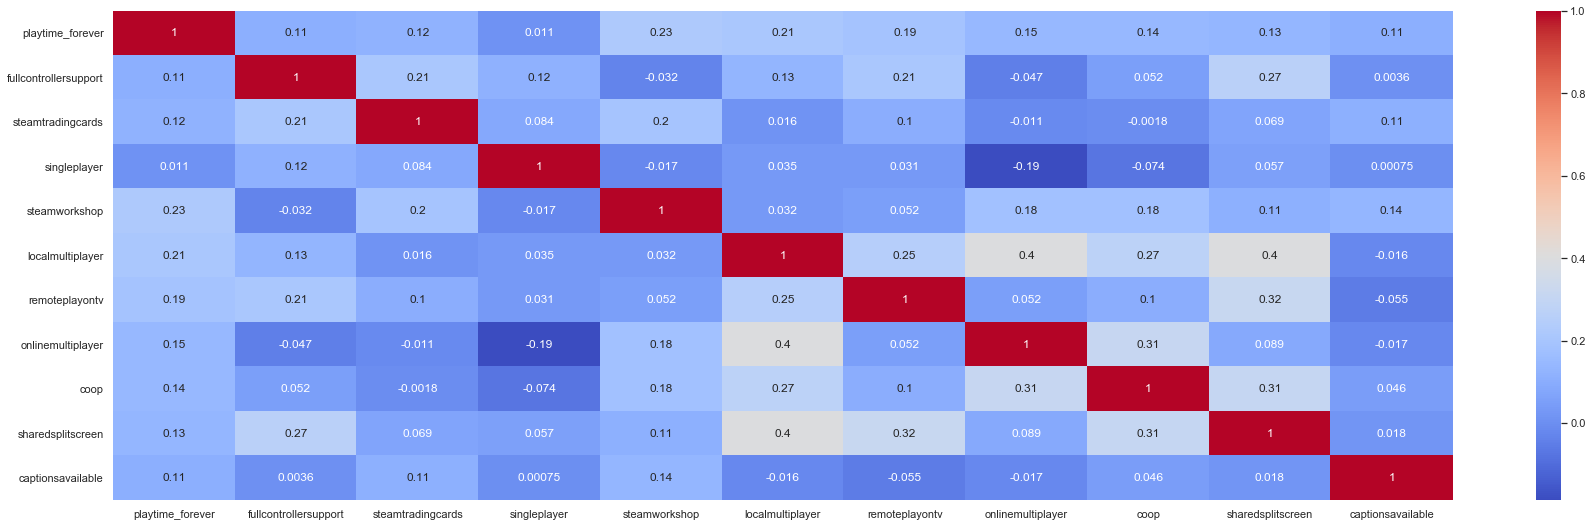

In [129]:
plot_heat_map(cate_df[['playtime_forever'] + cate_list].corr())

## tags

In [130]:
tag_df = create_cate_type_df(cate_type='tags')
tag_df

,playtime_forever,action,actionadventure,actionrpg,addictive,adventure,aliens,alternatehistory,america,animationmodeling,...,vr,walkingsimulator,war,wargame,warhammerk,western,worldwari,worldwarii,x,zombies
0,0.000000,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0.016667,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.000000,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.533333,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,22.333333,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,NaN,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
410,NaN,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
411,NaN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
412,NaN,1,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [131]:
test_tag_set = get_cate_type_data(game_info[train_len:], 'tags')
train_tag_set = get_cate_type_data(game_info[:train_len], 'tags')
tag_list = list(test_tag_set.intersection(train_tag_set))


In [132]:
with open('tag_list.txt', 'w') as f:
    for item in tag_list:
        f.write("%s\n" % item)

In [133]:
tag_df = tag_df[['playtime_forever'] + list(tag_list)]
tag_df

,playtime_forever,psychological,timetravel,realtime,indie,music,scifi,x,action,rhythm,...,darkhumor,military,d,oldschool,platformer,physics,cartoony,magic,singleplayer,basedonanovel
0,0.000000,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0.016667,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0.000000,0,0,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,1.533333,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
4,22.333333,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,NaN,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
410,NaN,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
411,NaN,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
412,NaN,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
tag_game_count = count_cate_game(tag_df).sort_values()
pd.options.display.max_rows = 4000

In [135]:
print(str(tag_game_count))

esports                             2
warhammerk                          2
gamesworkshop                       2
silentprotagonist                   2
musicbasedproceduralgeneration      2
worldwari                           2
shootemup                           2
america                             2
moba                                2
minigames                           2
epic                                3
heist                               3
inventorymanagement                 3
timemanipulation                    3
arenashooter                        3
western                             3
dinosaurs                           3
minimalist                          3
driving                             3
demons                              3
submarine                           3
parody                              3
mod                                 3
rpgmaker                            4
blood                               4
rhythm                              4
trading     

In [137]:
tag_df.corr().loc[:, 'rpg'].sort_values()

puzzle                           -0.254476
vr                               -0.241510
pointclick                       -0.232063
casual                           -0.194581
psychologicalhorror              -0.169781
mystery                          -0.160086
firstperson                      -0.156367
horror                           -0.138595
puzzleplatformer                 -0.127522
fps                              -0.125057
short                            -0.118975
thriller                         -0.116123
indie                            -0.115397
shooter                          -0.111920
platformer                       -0.104776
robots                           -0.103907
dvision                          -0.103907
worldwarii                       -0.103607
walkingsimulator                 -0.100045
surreal                          -0.097389
scifi                            -0.096703
gore                             -0.095268
simulation                       -0.094449
sports     

In [58]:
high_freq_tag = list(tag_game_count[tag_game_count.values >= 90].index)
high_freq_tag

['masterpiece',
 'simulation',
 'puzzle',
 'd',
 'coop',
 'fantasy',
 'scifi',
 'strategy',
 'openworld',
 'rpg',
 'multiplayer',
 'storyrich',
 'atmospheric',
 'greatsoundtrack',
 'indie',
 'action',
 'playtime_forever',
 'adventure',
 'singleplayer']

In [61]:
high_corr_tag_list = get_high_corr_list(tag_df.corr())

high_corr_tag_list

['turnbasedcombat',
 'turnbasedtactics',
 'partybasedrpg',
 'crpg',
 'rpg',
 'turnbased',
 'fantasy',
 'dungeoncrawler',
 'mouseonly',
 'coop',
 'roguelite',
 'proceduralgeneration',
 'pvp',
 'isometric',
 'crafting',
 'roguelike',
 'charactercustomization',
 'earlyaccess',
 'massivelymultiplayer',
 'multiplayer',
 'openworld',
 'replayvalue']

In [72]:
temp_tag_list = [e for e in high_corr_tag_list if e not in high_freq_tag]

temp_tag_list = high_freq_tag + temp_tag_list


temp_tag_list

['masterpiece',
 'simulation',
 'puzzle',
 'd',
 'coop',
 'fantasy',
 'scifi',
 'strategy',
 'openworld',
 'rpg',
 'multiplayer',
 'storyrich',
 'atmospheric',
 'greatsoundtrack',
 'indie',
 'action',
 'playtime_forever',
 'adventure',
 'singleplayer',
 'turnbasedcombat',
 'turnbasedtactics',
 'partybasedrpg',
 'crpg',
 'turnbased',
 'dungeoncrawler',
 'mouseonly',
 'roguelite',
 'proceduralgeneration',
 'pvp',
 'isometric',
 'crafting',
 'roguelike',
 'charactercustomization',
 'earlyaccess',
 'massivelymultiplayer',
 'replayvalue']

In [73]:
temp_tag_df = tag_df[['playtime_forever']+temp_tag_list]

temp_tag_df

,playtime_forever,masterpiece,simulation,puzzle,d,coop,fantasy,scifi,strategy,openworld,...,roguelite,proceduralgeneration,pvp,isometric,crafting,roguelike,charactercustomization,earlyaccess,massivelymultiplayer,replayvalue
0,0.000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.016667,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.000000,1,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.533333,0,1,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,22.333333,0,0,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,NaN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
410,NaN,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
411,NaN,0,1,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
412,NaN,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
corr_tag_df = temp_tag_df.corr()
cols_tag = corr_tag_df.columns
bt_tag = corr_tag_df.apply(lambda x: x > 0.4)
trap_tag = bt_tag.apply(lambda x: list(cols_tag[x.values]), axis=1)
trap_tag

playtime_forever                    [playtime_forever, playtime_forever]
masterpiece                                                [masterpiece]
simulation                                                  [simulation]
puzzle                                                          [puzzle]
d                                                                    [d]
coop                                                 [coop, multiplayer]
fantasy                                                   [fantasy, rpg]
scifi                                                            [scifi]
strategy                                                      [strategy]
openworld                                                    [openworld]
rpg                                                       [fantasy, rpg]
multiplayer                                          [coop, multiplayer]
storyrich                            [storyrich, atmospheric, adventure]
atmospheric                                     [st

# Putting Together

In [7]:
tag_list = ['masterpiece', 'greatsoundtrack', 'mouseonly', 'crafting', 'earlyaccess', 'replayvalue']

In [8]:
genre_list = ['rpg', 'adventure', 'strategy']
cate_list = ['fullcontrollersupport', 'steamtradingcards', 'steamworkshop','localmultiplayer','remoteplayontv','onlinemultiplayer', 'coop', 'sharedsplitscreen','captionsavailable']


In [9]:
cate_data = list(set(tag_list + genre_list + cate_list))
cate_data

['onlinemultiplayer',
 'greatsoundtrack',
 'masterpiece',
 'sharedsplitscreen',
 'captionsavailable',
 'steamtradingcards',
 'rpg',
 'remoteplayontv',
 'fullcontrollersupport',
 'adventure',
 'localmultiplayer',
 'coop',
 'steamworkshop',
 'replayvalue',
 'earlyaccess',
 'strategy',
 'crafting',
 'mouseonly']

In [40]:
num_data = ['playtime_forever', 'total_positive_reviews', 'time_interval', 'cate_count', 'price']

In [41]:
temp_cate_ds = game_info[['genres', 'categories', 'tags']]

def __unique_tags__(row):
    col1 = row.iloc[0]
    col2 = row.iloc[1]
    col3 = row.iloc[2]
    one_two = set(col1) | set(col2)
    return list(one_two | set(col3))

game_info.loc[:, 'all_cate'] = temp_cate_ds.apply(__unique_tags__, axis=1)
game_info.loc[:, 'cate_count'] = game_info['all_cate'].apply(lambda x: len(x))

In [42]:
game_data = game_info.copy()
cate_dataset = pd.get_dummies(game_data['all_cate'].apply(pd.Series).stack()).sum(level=0)
cate_dataset = cate_dataset.loc[:, cate_data]

num_dataset = game_info[num_data]

#game_data = pd.concat([num_dataset, cate_dataset], axis=1)
game_data = pd.concat([num_dataset], axis=1)
game_data

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,playtime_forever,total_positive_reviews,time_interval,cate_count,price
0,0.000000,372.0,5,16,3700.0
1,0.016667,23.0,1,8,0.0
2,0.000000,3018.0,4,24,5000.0
3,1.533333,63078.0,6,25,9900.0
4,22.333333,8841.0,6,26,4800.0
...,...,...,...,...,...
409,NaN,9334.0,5,26,5000.0
410,NaN,1245.0,9,21,3600.0
411,NaN,33128.0,5,27,11200.0
412,NaN,5.0,0,16,0.0


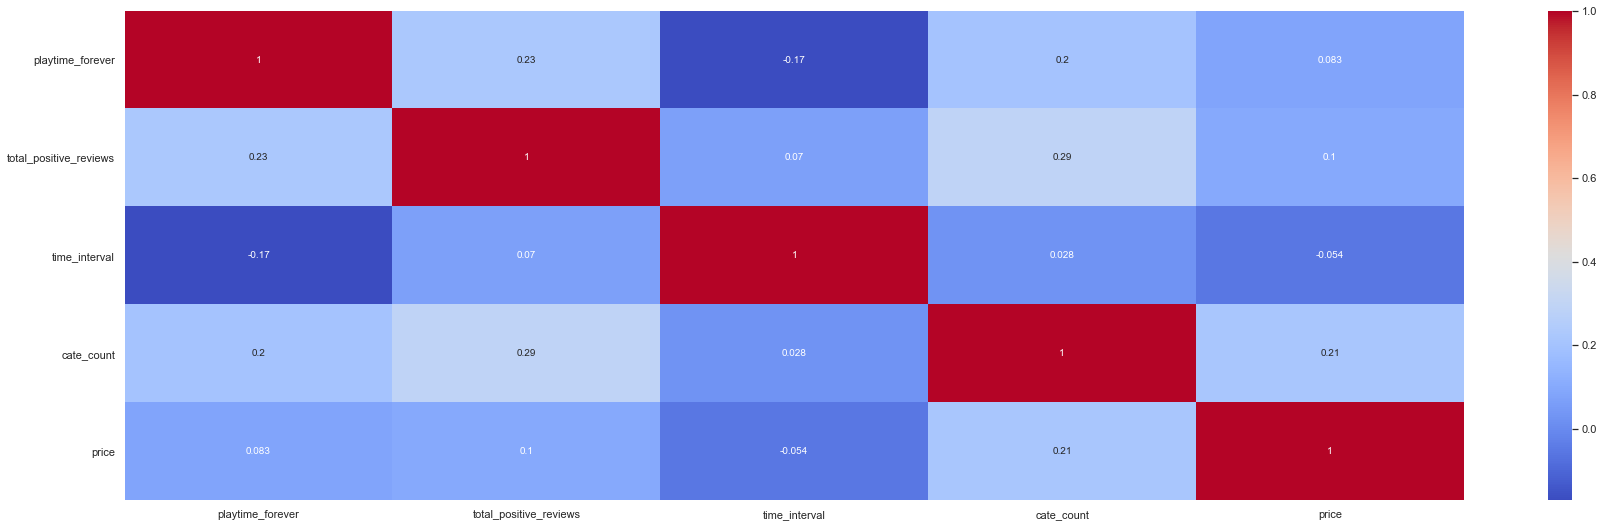

In [43]:
plot_heat_map(game_data.corr())

In [44]:
from sklearn import datasets, linear_model

from sklearn.decomposition import PCA


from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, Ridge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, ShuffleSplit
from sklearn.metrics import mean_squared_error, make_scorer
import xgboost as xgb
import lightgbm as lgb

In [45]:
train_data = game_data[:train_len]
test_data = game_data[train_len:]

train_label = train_data['playtime_forever']
train_data = train_data.drop(columns=['playtime_forever'])
test_data.drop(columns=['playtime_forever'],inplace=True)


print('train_data shape: ', train_data.shape)
print('train_label shape: ', train_label.shape)
print('test_data shape : ', test_data.shape)

train_data shape:  (324, 4)
train_label shape:  (324,)
test_data shape :  (90, 4)


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [46]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_data)
    rmse= np.sqrt(-cross_val_score(model, train_data, train_label, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [47]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

model_ridge = Ridge(alpha=0.0001, fit_intercept=True, normalize=True)

In [48]:
lasso_score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(lasso_score.mean(), lasso_score.std()))

enet_score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(enet_score.mean(), enet_score.std()))

# krr_score = rmsle_cv(KRR)
# print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(krr_score.mean(), krr_score.std()))

# gboost_score = rmsle_cv(GBoost)
# print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(gboost_score.mean(), gboost_score.std()))


xgb_score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(xgb_score.mean(), xgb_score.std()))


lgb_score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(lgb_score.mean(), lgb_score.std()))


ridge_score = rmsle_cv(model_ridge)
print("ridge score: {:.4f} ({:.4f})\n" .format(ridge_score.mean(), ridge_score.std()))



Lasso score: 7.1822 (2.4164)

ElasticNet score: 7.1822 (2.4164)



/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Xgboost score: 8.7651 (2.7259)

LGBM score: 6.0033 (2.1083)

ridge score: 7.1822 (2.4163)



In [49]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 

In [50]:
averaged_models = AveragingModels(models = (ENet, lasso, model_lgb))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))



 Averaged base models score: 6.3930 (2.2980)



In [51]:
X_train, X_val, y_train, y_val = train_test_split(train_data, train_label, test_size=0.2, random_state=42)



averaged_models.fit(X_train, y_train)
model_ridge.fit(X_train, y_train)
model_lgb.fit(X_train, y_train)

ave_pred = averaged_models.predict(X_val)
rid_pred = model_ridge.predict(X_val)
lgb_pred = model_lgb.predict(X_val)



print("LGB Root Mean squared error: ", np.sqrt(mean_squared_error(y_val, lgb_pred)))
print("Average Model Root Mean squared error: ", np.sqrt(mean_squared_error(y_val, ave_pred)))
print("Ridge Root Mean squared error: ", np.sqrt(mean_squared_error(y_val, rid_pred)))

LGB Root Mean squared error:  7.348292965330204
Average Model Root Mean squared error:  7.399152042415594
Ridge Root Mean squared error:  7.966724413883916


In [52]:
#model2.fit(X_train, y_train)
rid_test_pred = model_ridge.predict(test_data)

ave_test_pred = averaged_models.predict(test_data)

lgb_test_pred = model_lgb.predict(test_data)

In [53]:
def import_result(y_test_pred, filename):
    result_df = pd.DataFrame(y_test_pred, columns =['playtime_forever']) 
    result_df.index.name = 'id'
    result_df.to_csv(filename)

In [54]:
import_result(ave_test_pred, 'result.csv')